# Face Recognition

#### Project Description
In this hands-on project, the goal is to build a face identification model to recognize faces.

#### Dataset:  Aligned Face Dataset from Pinterest
This dataset contains 10.770 images for 100 people. All images are taken from
'Pinterest' and aligned using dlib library.

#### Overview
In this problem, we use a pre-trained model trained on Face recognition to recognize similar faces. Here, we are particularly interested in recognizing whether two given faces are of the same person or not. Below are the steps involved in the project.
- Load the dataset and create the metadata.
- Check some samples of metadata.
- Load the pre-trained model and weights.
- Generate Embedding vectors for each face in the dataset.
- Build distance metrics for identifying the distance between two given images.
- Use PCA for dimensionality reduction.
- Build SVM classifier to map each image to its right person.
- Predict using the SVM model.

##### Project Objectives
The objective of the project is to learn how to do transfer learning and how to use a pre-trained
model already trained on the desired task. In this project you are going to use transfer learning
to build face detection model and face recognition using pre-trained model The goals of this
assignment are as follows:
- Using a pre-trained model to do Face Recognition.
- Learn to use Triplet Loss.
- Learn to use SVM classifier for prediction.
- Learn to combine both the models to test

In [5]:
%tensorflow_version 2.x

import tensorflow as tf
tf.__version__

'2.1.0'

#### Mount Google drive if you are using google colab:

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Change current working directory to project folder:

In [7]:
import os
os.chdir('/content/drive/My Drive/Machine Learning/Face Recognition/')
print('CURRENT WORKING DIRECTORY:\n\n' , os.getcwd())

CURRENT WORKING DIRECTORY:

 /content/drive/My Drive/Machine Learning/Face Recognition


#### Extract the zip file:
Extract Aligned Face Dataset from Pinterest.zip

In [8]:
from zipfile import ZipFile

with ZipFile('Aligned Face Dataset from Pinterest.zip', 'r') as z:
   z.extractall() 

!ls

'Aligned Face Dataset from Pinterest.zip'   pins   vgg_face_weights.h5
 Face_Recognition.ipynb			    PINS


#### Function to load images:
Define a function to load the images from the extracted folder and map each image with person id

In [0]:
import numpy as np
import os

class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

# metadata = load_metadata('images')
metadata = load_metadata('PINS')

#### Define function to load image:
Define a function to load image from the metadata

In [0]:
import cv2
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels in BGR order. So we need to reverse them
    return img[...,::-1]

#### Load a sample image:
Load one image using the function 'load_image'

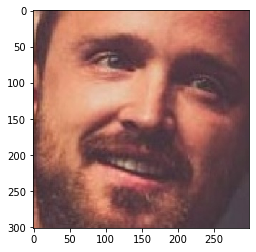

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

n = 0
load_image(metadata[n].image_path())
plt.figure()

# Show image
plt.imshow(load_image(metadata[n].image_path()))

#### VGG Face model:
Here we are giving you the predefined model for VGG face

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

#### Load the model:
- Load the model defined above
- Then load the given weight file named "vgg_face_weights.h5"

In [0]:
model = vgg_face()
model.load_weights('vgg_face_weights.h5')

#### Get vgg_face_descriptor:

In [0]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

#### Generate embeddings for each image in the dataset:
Given below is an example to load the first image in the metadata and get its embedding vector from the pre-trained model.

In [17]:
# Get embedding vector for first image in the metadata using the pre-trained model
img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 

embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
(2622,)


#### Generate embeddings for all images:

In [0]:
embeddings = []
for n in range(0, len(metadata)):
    img = load_image(metadata[n].image_path())
    img = (img / 255.).astype(np.float32)
    img = cv2.resize(img, dsize = (224,224))
    embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis=0))[0]
    embeddings.append(embedding_vector)

#### Function to calculate distance between given 2 pairs of images.

- Consider distance metric as "Squared L2 distance"
- Squared l2 distance between 2 points (x1, y1) and (x2, y2) = (x1-x2)^2 + (y1-y2)^2

In [0]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

#### Plot images and get distance between the pairs given below:
- 2, 3 and 2, 180
- 30, 31 and 30, 100
- 70, 72 and 70, 115

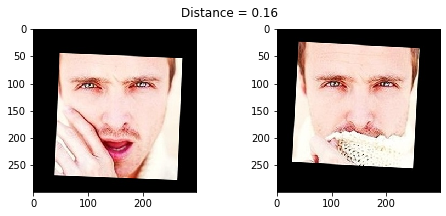

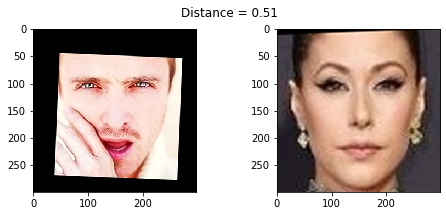

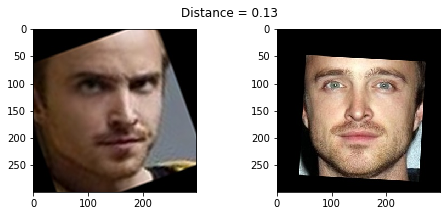

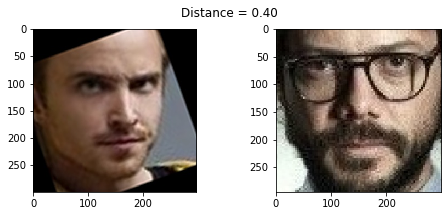

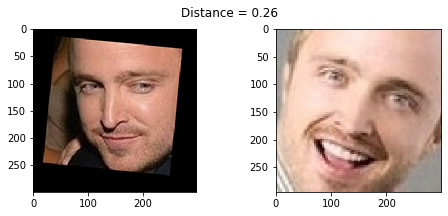

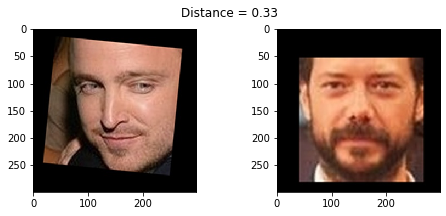

In [20]:
import matplotlib.pyplot as plt

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(2, 3)
show_pair(2, 180)
show_pair(30, 31)
show_pair(30, 100)
show_pair(70, 72)
show_pair(70, 115)

#### Create train and test sets:

In [35]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

y = np.array([(m.name) for m in metadata])

X_train = np.array(embeddings)[train_idx]
X_test = np.array(embeddings)[test_idx]
y_train = y[train_idx]
y_test = y[test_idx]

print('X_train = {} values'.format(len(X_train)))
print('X_test = {} values\n'.format(len(X_test)))
print('y_train = {} values'.format(len(y_train)))
print('y_test = {} values'.format(len(y_test)))

X_train = 9573 values
X_test = 1197 values

y_train = 9573 values
y_test = 1197 values


#### Encode the Labels:

In [0]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

#### Standardize the feature values:

In [0]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#### Reduce dimensions using PCA:

348 Principal Components are required to exaplin 95% of the variance


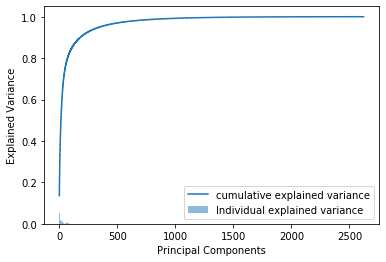

In [38]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
plt.step(range(1, cumsum.shape[0]+1), cumsum, where= 'mid', label='cumulative explained variance')
plt.bar(range(1, cumsum.shape[0]+1), pca.explained_variance_ratio_, alpha = 0.5, align = 'center', label = 'Individual explained variance')
plt.ylabel('Explained Variance')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')
print('{} Principal Components are required to exaplin 95% of the variance'.format(d))
plt.show()

pca = PCA(n_components=d)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

#### Hyperparameter tuning using a SVC:

In [53]:
from sklearn.metrics import make_scorer
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC

def tuning(model,
           parameters,
           iteration = 50,
           n_folds = 10,
           X = X_train,
           y = y_train,
           scorer = make_scorer(accuracy_score), 
           estimation = True):
    """
    Return the best combination of hyperparameters
    model: model to tune
    parameters: grid of hyperparameters
    iteration: number of combinations to try randomly
    n_fold: number of folds used in the cross-validation
    score: specify what is the score/target of the problem
    estimation: after 5 loops, it prints the expected execution time
    """
    
    if estimation==True:
        start1=datetime.now()
        randomCV1 = RandomizedSearchCV(model,
                                       param_distributions=parameters,
                                       n_iter=5,
                                       cv=n_folds,
                                       random_state=1)
        randomCV1.fit(X, y)
        stop1=datetime.now()
        execution_time1 = stop1-start1
        print('Expected execution time is about',iteration*execution_time1/5,'\n')
    
    start=datetime.now()
    randomCV = RandomizedSearchCV(model,
                                  param_distributions=parameters,
                                  n_iter=iteration,
                                  cv=n_folds,
                                  scoring=scorer,
                                  random_state=1)
    randomCV.fit(X, y)
    stop=datetime.now()
    execution_time = stop-start
    print('Execution time =',execution_time,'\n')
    print('\nTHE BEST COMBINATION OF HYPERPARAMETERS IS:\n\n',randomCV.best_params_)

param_dist = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 
              'C': np.linspace(0.1,10,100),
              'gamma': np.linspace(0.1,10,100)}

tuning(model = SVC(random_state=1), 
       parameters = param_dist,
       iteration = 10,
       n_folds = 3,
       estimation = False)

Execution time = 0:08:52.467973 


THE BEST COMBINATION OF HYPERPARAMETERS IS:

 {'kernel': 'linear', 'gamma': 4.3999999999999995, 'C': 3.1}


#### Build the Classifier and check the accuracy:

In [54]:
svm_hyperparameters = {'kernel': 'linear', 
                       'gamma': 4.4, 
                       'C': 3.1}

svc = SVC(kernel=svm_hyperparameters.get('kernel'),
          gamma=svm_hyperparameters.get('gamma'),
          C=svm_hyperparameters.get('C'),
          random_state=1)

svc.fit(X_train, y_train)
acc = accuracy_score(y_test, svc.predict(X_test))
print('SVC accuracy = {:.2f}'.format(acc))

SVC accuracy = 0.96


#### Test results:
Plot 5 random images from test set and report to which person (folder name in dataset) the image belongs to

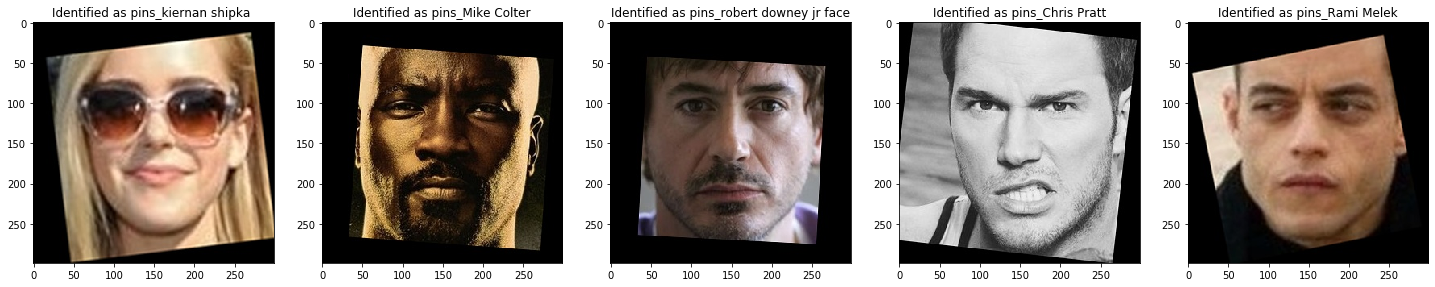

In [80]:
import matplotlib.pyplot as plt
import random
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

fig = plt.figure(figsize=(5*charts_length,5)) 

for c in range(0,5): 
    plt.subplot(1,5,c+1) 
    example_idx = int(random.uniform(0, len(metadata[test_idx])))
    example_image = load_image(metadata[test_idx][example_idx].image_path())
    example_prediction =  svc.predict(np.reshape(X_test[example_idx], (1, d)))
    example_identity = encoder.inverse_transform(example_prediction)[0]
    plt.title(f'Identified as {example_identity}') 
    plt.imshow(example_image)
        
plt.show() 